# Graph-to-Combinatorial N-Hop Lifting Tutorial

***
This notebook shows how to import a dataset, with the desired lifting, and how to run a neural network using the loaded data.

The notebook is divided into sections:

- [Loading the dataset](#loading-the-dataset) loads the config files for the data and the desired tranformation, createsa a dataset object and visualizes it.
- [Loading and applying the lifting](#loading-and-applying-the-lifting) defines a simple neural network to test that the lifting creates the expected incidence matrices.
- [Create and run a simplicial nn model](#create-and-run-a-simplicial-nn-model) simply runs a forward pass of the model to check that everything is working as expected.

***
***

Note that for simplicity the notebook is setup to use a simple graph. However, there is a set of available datasets that you can play with.

To switch to one of the available datasets, simply change the *dataset_name* variable in [Dataset config](#dataset-config) to one of the following names:

* cocitation_cora
* cocitation_citeseer
* cocitation_pubmed
* MUTAG
* NCI1
* NCI109
* PROTEINS_TU
* AQSOL
* ZINC
***

### Imports and utilities

In [1]:
%load_ext autoreload
%autoreload 2
from modules.data.load.loaders import GraphLoader
from modules.data.preprocess.preprocessor import PreProcessor
from modules.utils.utils import (
    describe_data,
    load_dataset_config,
    load_model_config,
    load_transform_config,
)

## Loading the Dataset

Here we just need to spicify the name of the available dataset that we want to load. First, the dataset config is read from the corresponding yaml file (located at `/configs/datasets/` directory), and then the data is loaded via the implemented `Loaders`.


In [2]:
dataset_name = "manual_dataset"
dataset_config = load_dataset_config(dataset_name)
loader = GraphLoader(dataset_config)


Dataset configuration for manual_dataset:

{'data_domain': 'graph',
 'data_type': 'toy_dataset',
 'data_name': 'manual',
 'data_dir': 'datasets/graph/toy_dataset',
 'num_features': 1,
 'num_classes': 2,
 'task': 'classification',
 'loss_type': 'cross_entropy',
 'monitor_metric': 'accuracy',
 'task_level': 'node'}


We can then access to the data through the `load()`method:


Dataset only contains 1 sample:


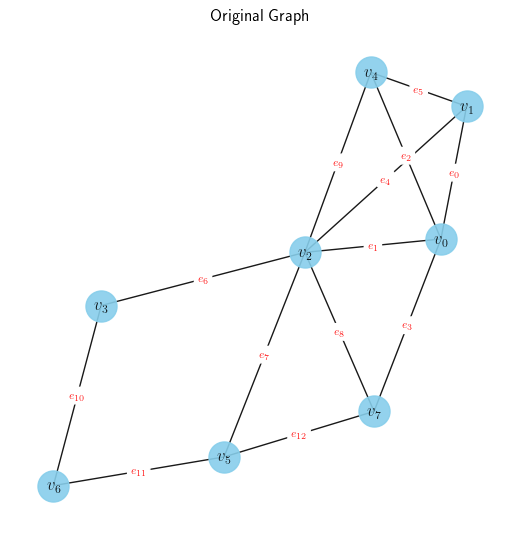

 - Graph with 8 vertices and 13 edges.
 - Features dimensions: [1, 0]
 - There are 0 isolated nodes.



In [3]:
dataset = loader.load()
describe_data(dataset)

## Loading and Applying the Lifting

In this section we will instantiate the lifting we want to apply to the data. For this example the n-hop neighbourhood lifting was chosen. This technique retains the regulas graph vertices and edges as 0-cells and 1-cells and adds hyperedge cells as n-cells based on the n-hop neighbourhood of each node. Formally $\mathcal{N}(v_i, k) = \{v_j | d(v_i, v_j) < n\}$, to do this we can exploit the fact that the adjacency matrix of an undirected unweighted graph $G$ named $A$ will contain the 1-hop distances of all nodes. Squaring the matrix such that we have $A^n$ will give use the n-hop distances. The proof that this satisfies the criteria for a Combinatorial Complex is in [[1]](https://arxiv.org/abs/2206.00606)

***
[[1]](https://arxiv.org/abs/2206.00606) Hajij, Mustafa, et al. "Topological deep learning: Going beyond graph data." arXiv preprint arXiv:2206.00606 (2022).
***

For combinatorial complexes creating a lifting involves creating a `CombinatorialComplex` object from topomodelx and adding their n-hop neighbours as hyperedges to it. The `CombinatorialComplex` class then takes care of creating all the needed matrices.

Similarly to before, we can specify the transformation we want to apply through its type and id --the correxponding config files located at `/configs/transforms`. 

Note that the *tranform_config* dictionary generated below can contain a sequence of tranforms if it is needed.

This can also be used to explore liftings from one topological domain to another, for example using two liftings it is possible to achieve a sequence such as: graph -> simplicial complex -> hypergraph. 

In [4]:

# Define transformation type and id
transform_type = "liftings"
# If the transform is a topological lifting, it should include both the type of the lifting and the identifier
transform_id = "graph2combinatorial/n_hop_lifting"

# Read yaml file
transform_config = {
    "lifting": load_transform_config(transform_type, transform_id)
    # other transforms (e.g. data manipulations, feature liftings) can be added here
}


Transform configuration for graph2combinatorial/n_hop_lifting:

{'transform_type': 'lifting',
 'transform_name': 'NHopLifting',
 'hop_num': 1,
 'feature_lifting': 'ProjectionSum'}


Transform parameters are the same, using existing data_dir: /Users/martincarrasco/Documents/VU/research/tdl/challenge-icml-2024/datasets/graph/toy_dataset/manual/lifting/3608493167

Dataset only contains 1 sample:


Processing...
/Users/martincarrasco/Documents/VU/research/tdl/challenge-icml-2024/modules/transforms/liftings/graph2combinatorial/n_hop_lifting.py:32: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_mat = nx.adjacency_matrix(graph)
Done!


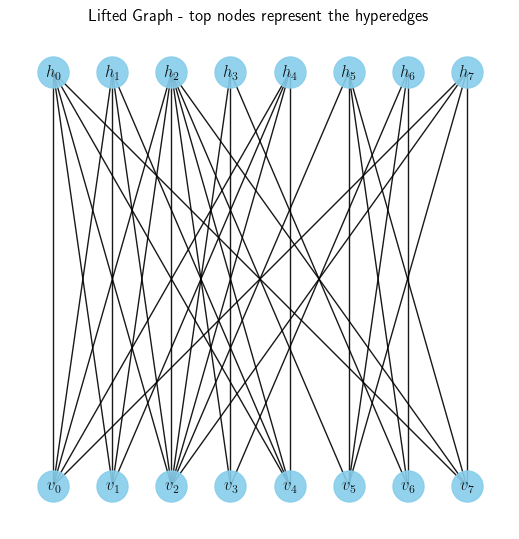

 - Hypergraph with 8 vertices and 8 hyperedges.
 - The nodes have feature dimensions 1.
 - The hyperedges have feature dimensions 1.



In [10]:
lifted_dataset = PreProcessor(dataset, transform_config, loader.data_dir, force_reload=True)
describe_data(lifted_dataset)

In [12]:
from modules.models.hypergraph.unigcn import UniGCNModel

model_type = "hypergraph"
model_id = "unigcn"
model_config = load_model_config(model_type, model_id)

model = UniGCNModel(model_config, dataset_config)


Model configuration for hypergraph UNIGCN:

{'in_channels': None,
 'hidden_channels': 32,
 'out_channels': None,
 'n_layers': 2}


In [11]:

y_hat = model(lifted_dataset.get(0))